In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.nn import functional as F
from torch.nn import Sequential, Tanh, Parameter
import mlflow as mlflow
%matplotlib inline

In [235]:
torch.manual_seed(42);

In [236]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [237]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [238]:
len(vocab)

27

In [239]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [240]:
torch.set_default_device("cpu")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)

train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

#hyperparameters
n_context = 8
e_dim = 10
h_dim = 200
n_consec = 2

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182555, 8]) torch.Size([182555])
torch.Size([22685, 8]) torch.Size([22685])
torch.Size([22906, 8]) torch.Size([22906])


In [260]:
class Linear(torch.nn.Module):
    def __init__(self,nin,nout,bias=True,weight=1):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.weights = Parameter(torch.randn(nin, nout) * weight)
        self.bias = Parameter(torch.randn(nout)) if bias else None

    
    def forward(self,x):
        self.out = x @ self.weights * self.nin**-0.5
        if self.bias != None:
            self.out = self.out + self.bias
        return self.out 

    # def parameters(self):
    #     self.parameters = [self.W1] + [self.b1] if self.b1!=None else [self.W1]
    #     return self.parameters 
        
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
        
class Embedding(torch.nn.Module):
    def __init__(self,vocab_size,edim):
        super().__init__()
        self.weights = Parameter(torch.randn(vocab_size, edim))

    def forward(self,x):
        self.out = self.weights[x]
        return self.out

    # def parameters(self):
    #     self.parameters = [self.embedding]
    #     return self.parameters

class BatchNorm1d(torch.nn.Module):
    def __init__(self,nout,alpha=0.001,eps=1e-05):
        super().__init__()
        self.nout = nout
        self.bgain = Parameter(torch.ones(1,nout))
        self.bbias = Parameter(torch.zeros(1,nout))
        self.bstdrunning = torch.ones(1,nout)
        self.bmeanrunning = torch.zeros(1,nout)
        self.alpha = alpha
        self.eps = eps
        
    def forward(self,x):
        if(self.training):
            dimn = len(x.shape) -1
            # print([*range(dimn)])
            bmeani = x.mean([*range(dimn)],keepdim=True)
            bstdi = x.std([*range(dimn)],keepdim = True)
            self.out = self.bgain*(x - bmeani)/ (bstdi + self.eps) + self.bbias
            with torch.no_grad():
                self.bmeanrunning = self.alpha * self.bmeanrunning + (1 - self.alpha)* bmeani
                self.bstdrunning = self.alpha * self.bstdrunning + (1 - self.alpha) * bstdi
        else:
            self.out = self.bgain*(x - self.bmeanrunning)/ (self.bstdrunning + self.eps) + self.bbias

        return self.out
   
    # def parameters(self):
    #     self.parameters = [self.bgain,self.bbias]
    #     return self.parameters

class FlattenConsecutive(torch.nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n = n

    def forward(self,x):
        B,T,C = x.shape
        x=x.view(B,T//self.n,C * self.n)
        if x.shape[1] == 1:
           x =  x.squeeze(1)
        self.out = x
        return self.out

class Tanh1(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = F.tanh(x)
        return self.out
        
@torch.no_grad()
def evaluate(X,Y,model):
    model.eval()
    out = model(X)
    loss = F.cross_entropy(out,Y)
    return out,loss

@torch.no_grad()
def generate(n_words,model):
    model.eval()
    for i in range(10):
        #forward pass
        out = []
        context = [0] * 8
        while True:
            logits= model(torch.tensor(context).view(1,-1))
            p = F.softmax(logits,dim=1)
            ix = torch.multinomial(p,num_samples = 1, replacement = True)
            context = context[1:] + [ix.item()]
            if ix.item() == 0:
                break
            out.append(itos[ix.item()])
        print("".join(out))


In [261]:
Model =  Sequential(
    Embedding(len(vocab),e_dim),
    FlattenConsecutive(n_consec),Linear(n_consec*e_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    FlattenConsecutive(n_consec),Linear(n_consec*h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    FlattenConsecutive(n_consec),Linear(n_consec*h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,len(vocab),weight=0.1)
    
)

In [267]:
batch_size = 32
lrsloss = []
lossi = []

for i in range(200000):
    #forward pass
    lr = 0.01 if i <100000 else 0.001
    Model.train()
    # optimizer = torch.optim.SGD(Model.parameters(), lr=lr)
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    out= Model.forward(Xtr[ix])
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    #backpass
    for p in Model.parameters():
        p.grad = None
    loss.backward()
    for p in Model.parameters():
        p.data += -lr*p.grad

    # if i == 1:
    #     break
        

print(F" Final loss: {loss.item():.4f}")

loss at 0/200000 2.0912
loss at 10000/200000 1.9376
loss at 20000/200000 2.4595
loss at 30000/200000 2.4942
loss at 40000/200000 2.4954
loss at 50000/200000 1.9854
loss at 60000/200000 2.1911
loss at 70000/200000 1.8588
loss at 80000/200000 1.9869
loss at 90000/200000 2.0842
loss at 100000/200000 2.1037
loss at 110000/200000 2.1860
loss at 120000/200000 1.8637
loss at 130000/200000 2.3891
loss at 140000/200000 1.9760
loss at 150000/200000 2.2426
loss at 160000/200000 2.2722
loss at 170000/200000 2.2827
loss at 180000/200000 2.1858
loss at 190000/200000 2.1578
 Final loss: 2.1491


In [270]:
evaluate(Xdev,Ydev,Model)

(tensor([[-3.5155,  1.9880,  0.4904,  ..., -1.7853, -0.7339,  0.2316],
         [-1.9495,  4.1008, -0.8621,  ..., -2.5974,  1.5251, -1.4164],
         [-1.4945,  5.8706, -1.4039,  ..., -2.1532,  3.3743, -1.4991],
         ...,
         [ 1.7722,  4.2436, -1.7643,  ..., -1.9722,  4.4363, -1.9818],
         [ 1.6928,  2.7534, -1.7121,  ..., -1.2866,  0.8798, -0.6502],
         [ 5.0236,  0.8078, -1.1163,  ..., -1.8750, -0.4871, -0.8065]]),
 tensor(2.1582))

In [271]:
evaluate(Xtest,Ytest,Model)

(tensor([[-3.5155,  1.9880,  0.4904,  ..., -1.7853, -0.7339,  0.2316],
         [-3.1064,  0.8188,  0.3920,  ..., -1.1439,  0.2750,  0.4416],
         [-1.3417,  2.0708, -0.2922,  ..., -2.1954,  1.6419, -0.5874],
         ...,
         [ 2.1880,  4.3863, -1.4140,  ..., -2.0419,  1.6373, -1.1154],
         [ 1.7268,  0.5208, -1.0239,  ..., -1.1044, -0.2559, -0.8826],
         [ 3.4785,  2.6087, -1.6862,  ..., -2.5090,  0.7172, -1.3607]]),
 tensor(2.1408))

In [272]:
generate(10,Model)

cili
elena
moitas
adzie
grer
araxiah
wih
fyaami
kenliley
hanak


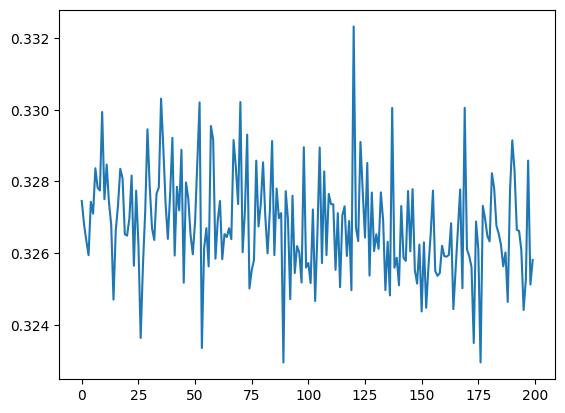

In [273]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))